In [19]:
import os
import sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import optuna
from sklearn.metrics import mean_squared_error, log_loss

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

from src.data_loading import download_daily_prices, load_daily_close
from src.signals import (
    make_basic_signals,
    build_feature_matrix,
    build_sequence_dataset,
    DEFAULT_FEATURES,
)
from src.models_tree import train_tree_regressor, evaluate_regression
from src.models_lstm_class import train_lstm_classifier, predict_lstm_proba
from src.models_lstm import train_lstm_regressor, predict_lstm
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)
from src.models_tcn import train_tcn_regressor, predict_tcn



PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def sharpe_ratio_np(returns: np.ndarray, freq: int = 252) -> float:
    """Simple annualized Sharpe on a 1D array of daily returns."""
    mean = returns.mean()
    std = returns.std()
    if std == 0:
        return 0.0
    return np.sqrt(freq) * mean / std


In [21]:
ticker = "SPY"

# Load or download prices
try:
    prices = load_daily_close(ticker)
except FileNotFoundError:
    download_daily_prices(ticker, start="2010-01-01")
    prices = load_daily_close(ticker)

signals_df = make_basic_signals(prices)
signals_df.head(), signals_df.columns


c:\Users\gehra\Documents\GitHub\Quant_coding\src\data_loading.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=[0], index_col=0)


(                price     ret_1     ret_5    ret_10    ret_21    vol_10  \
 date                                                                      
 2010-10-18  90.276466  0.004928  0.013973  0.039824  0.051472  0.006651   
 2010-10-19  89.093422 -0.013105 -0.002393  0.005946  0.022065  0.005921   
 2010-10-20  89.963554  0.009767 -0.000424  0.015858  0.034129  0.006576   
 2010-10-21  90.161972  0.002206  0.005704  0.019329  0.041527  0.006503   
 2010-10-22  90.329887  0.001862  0.005523  0.015531  0.052000  0.006374   
 
               vol_20    vol_60  vol_ratio_10_60  ma10_rel  ma20_rel  ma50_rel  \
 date                                                                            
 2010-10-18  0.007711  0.009786         0.679635 -0.011228 -0.023444 -0.056598   
 2010-10-19  0.008369  0.009886         0.598926  0.002493 -0.009299 -0.043327   
 2010-10-20  0.008446  0.009951         0.660826 -0.005642 -0.016994 -0.051547   
 2010-10-21  0.008106  0.009904         0.656599 -0.0059

In [22]:
feature_names = DEFAULT_FEATURES

X, y, dates = build_feature_matrix(signals_df, feature_names)

split_idx = int(len(X) * 0.7)  # 70% train / 30% test

X_train, X_test = X[:split_idx], X[split_idx:]
y_train_float, y_test_float = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Train period:", dates_train[0], "->", dates_train[-1])
print("Test period:", dates_test[0], "->", dates_test[-1])

# Standardise features for LSTM regressor
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape


Train size: 2664 Test size: 1143
Train period: 2010-10-18 00:00:00 -> 2021-05-18 00:00:00
Test period: 2021-05-19 00:00:00 -> 2025-12-04 00:00:00


((2664, 15), (1143, 15))

In [23]:
# ---------------------------
# Optuna tuning: Tree model (Sharpe-based)
# ---------------------------
def objective_tree(trial):
    # Hyperparameters of the tree
    max_depth = trial.suggest_int("max_depth", 2, 8)
    max_iter = trial.suggest_int("max_iter", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    l2_reg = trial.suggest_float("l2_regularization", 0.0, 1.0)

    # Trading hyperparameter: quantile for threshold
    q = trial.suggest_float("q", 0.4, 0.9)  # e.g. 40%–90% quantile

    # Chronological split of X_train into inner-train / validation
    n = len(X_train)
    split = int(n * 0.8)
    X_tr, X_val = X_train[:split], X_train[split:]
    y_tr, y_val = y_train_float[:split], y_train_float[split:]

    # Train tree on inner-train
    model = train_tree_regressor(
        X_tr,
        y_tr,
        max_depth=max_depth,
        max_iter=max_iter,
        learning_rate=learning_rate,
        l2_regularization=l2_reg,
    )

    # Predict on inner-val
    preds_val = model.predict(X_val)

    # Ranking rule on validation:
    # only long when prediction is above q-quantile of preds_val
    tau_val = np.quantile(preds_val, q)
    positions_val = (preds_val > tau_val).astype(int)
    strat_ret_val = positions_val * y_val  # actual next-day returns

    # Strategy Sharpe on validation slice
    sharpe_val = sharpe_ratio_np(strat_ret_val)

    # Optuna minimizes -> return negative Sharpe
    return -sharpe_val



study_tree = optuna.create_study(direction="minimize")
study_tree.optimize(objective_tree, n_trials=10)

print("Best tree params:", study_tree.best_params)


[I 2025-12-12 14:24:16,004] A new study created in memory with name: no-name-eab2359a-917c-4157-83f1-e267f8d8237e
[I 2025-12-12 14:24:17,598] Trial 0 finished with value: -0.6613807871071269 and parameters: {'max_depth': 8, 'max_iter': 486, 'learning_rate': 0.010116924111979167, 'l2_regularization': 0.8546417954980587, 'q': 0.5921533563936516}. Best is trial 0 with value: -0.6613807871071269.
[I 2025-12-12 14:24:19,815] Trial 1 finished with value: -0.6938772493741906 and parameters: {'max_depth': 6, 'max_iter': 324, 'learning_rate': 0.04511082557578816, 'l2_regularization': 0.25325336276474575, 'q': 0.5837838436992004}. Best is trial 1 with value: -0.6938772493741906.
[I 2025-12-12 14:24:20,801] Trial 2 finished with value: -0.9959254334630456 and parameters: {'max_depth': 6, 'max_iter': 414, 'learning_rate': 0.10923269950775015, 'l2_regularization': 0.7525142095860016, 'q': 0.47867738815792865}. Best is trial 2 with value: -0.9959254334630456.
[I 2025-12-12 14:24:20,956] Trial 3 fini

Best tree params: {'max_depth': 4, 'max_iter': 212, 'learning_rate': 0.010953585620510933, 'l2_regularization': 0.06305942765614436, 'q': 0.4020856176117329}


In [24]:
# --- Tree with best Optuna params (model + trading rule) ---
best_tree_params = study_tree.best_params
q_tree = best_tree_params["q"]

# Params for the sklearn model (exclude q)
tree_model_params = {k: v for k, v in best_tree_params.items() if k != "q"}

tree_model = train_tree_regressor(
    X_train,
    y_train_float,
    **tree_model_params,
)

# Predictions on train/test
preds_tree_train = tree_model.predict(X_train)
preds_tree_test  = tree_model.predict(X_test)

# Threshold based on train predictions and tuned q
tau_tree = np.quantile(preds_tree_train, q_tree)
print("Tree q_best:", q_tree, " -> tau_tree:", tau_tree)

# Trading rule on test
positions_tree = (preds_tree_test > tau_tree).astype(int)

# Returns on full test period
bh_returns = y_test_float                              # buy & hold
tree_returns = positions_tree * y_test_float           # tree strategy

# Series for full test period (we'll align later)
bh_series_full = signals_df["target_ret_1"].iloc[split_idx:].copy()
bh_series_full[:] = bh_returns

tree_series_full = bh_series_full.copy()
tree_series_full[:] = tree_returns


bh_series_full.head(), tree_series_full.head()


Tree q_best: 0.4020856176117329  -> tau_tree: 0.00044200525882216886


(date
 2021-05-19    0.010758
 2021-05-20   -0.000819
 2021-05-21    0.010194
 2021-05-24   -0.002219
 2021-05-25    0.001985
 Name: target_ret_1, dtype: float64,
 date
 2021-05-19    0.0
 2021-05-20   -0.0
 2021-05-21    0.0
 2021-05-24   -0.0
 2021-05-25    0.0
 Name: target_ret_1, dtype: float64)

In [25]:
# Direction labels for single-day features (no sequences)
y_train_class_simple = (y_train_float > 0).astype(int)
y_test_class_simple  = (y_test_float > 0).astype(int)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train_class_simple)

y_pred_simple = log_reg.predict(X_test)

base_rate_simple = y_test_class_simple.mean()
acc_simple = accuracy_score(y_test_class_simple, y_pred_simple)
bacc_simple = balanced_accuracy_score(y_test_class_simple, y_pred_simple)

print("Base rate (simple):", base_rate_simple)
print("LogReg accuracy:", acc_simple)
print("LogReg balanced acc:", bacc_simple)


Base rate (simple): 0.5476815398075241
LogReg accuracy: 0.5476815398075241
LogReg balanced acc: 0.5


In [26]:
seq_len = 30

# --- Sequences for CLASSIFIER (unscaled features) ---
X_train_seq, y_train_seq_float, dates_train_seq = build_sequence_dataset(
    X_train, y_train_float, dates_train, seq_len=seq_len
)
X_test_seq, y_test_seq_float, dates_test_seq = build_sequence_dataset(
    X_test, y_test_float, dates_test, seq_len=seq_len
)

# Labels for classifier
y_train_seq_class = (y_train_seq_float > 0).astype(np.float32)
y_test_seq_class  = (y_test_seq_float > 0).astype(np.float32)

print("Classifier sequences:", X_train_seq.shape, X_test_seq.shape)
print("Fraction up days (train/test):", y_train_seq_class.mean(), y_test_seq_class.mean())

# --- Sequences for REGRESSOR (scaled features) ---
X_train_seq_reg, y_train_seq_reg_float, dates_train_seq_reg = build_sequence_dataset(
    X_train_scaled, y_train_float, dates_train, seq_len=seq_len
)
X_test_seq_reg, y_test_seq_reg_float, dates_test_seq_reg = build_sequence_dataset(
    X_test_scaled, y_test_float, dates_test, seq_len=seq_len
)

print("Regressor sequences:", X_train_seq_reg.shape, X_test_seq_reg.shape)
print("First test seq date (cls/reg):", dates_test_seq[0], dates_test_seq_reg[0])


Classifier sequences: (2635, 30, 15) (1114, 30, 15)
Fraction up days (train/test): 0.55749524 0.54578096
Regressor sequences: (2635, 30, 15) (1114, 30, 15)
First test seq date (cls/reg): 2021-06-30 00:00:00 2021-06-30 00:00:00


In [27]:
# ---------------------------
# Optuna tuning: LSTM Classifier
# ---------------------------
def objective_lstm_cls(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64)
    num_layers = trial.suggest_int("num_layers", 1, 10)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 10, 40)

    n = len(X_train_seq)
    split = int(n * 0.7)
    X_tr_seq = X_train_seq[:split]
    X_val_seq = X_train_seq[split:]
    y_tr_seq = y_train_seq_class[:split]
    y_val_seq = y_train_seq_class[split:]

    model = train_lstm_classifier(
        X_tr_seq,
        y_tr_seq,
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=lr,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
    )

    p_up_val = predict_lstm_proba(model, X_val_seq)
    # Log-loss on validation as objective
    loss_val = log_loss(y_val_seq, p_up_val)
    return loss_val


study_lstm_cls = optuna.create_study(direction="minimize")
study_lstm_cls.optimize(objective_lstm_cls, n_trials=10)

print("Best LSTM cls params:", study_lstm_cls.best_params)


[I 2025-12-12 14:24:33,677] A new study created in memory with name: no-name-f6a4528e-74c6-46c0-8cb6-18760ba6f185


Epoch 1/26 - train BCE: 0.6898
Epoch 2/26 - train BCE: 0.6887
Epoch 3/26 - train BCE: 0.6881
Epoch 4/26 - train BCE: 0.6877
Epoch 5/26 - train BCE: 0.6875
Epoch 6/26 - train BCE: 0.6874
Epoch 7/26 - train BCE: 0.6875
Epoch 8/26 - train BCE: 0.6873
Epoch 9/26 - train BCE: 0.6874
Epoch 10/26 - train BCE: 0.6874
Epoch 11/26 - train BCE: 0.6872
Epoch 12/26 - train BCE: 0.6872
Epoch 13/26 - train BCE: 0.6872
Epoch 14/26 - train BCE: 0.6873
Epoch 15/26 - train BCE: 0.6871
Epoch 16/26 - train BCE: 0.6871
Epoch 17/26 - train BCE: 0.6870
Epoch 18/26 - train BCE: 0.6870
Epoch 19/26 - train BCE: 0.6870
Epoch 20/26 - train BCE: 0.6867
Epoch 21/26 - train BCE: 0.6868
Epoch 22/26 - train BCE: 0.6867
Epoch 23/26 - train BCE: 0.6864
Epoch 24/26 - train BCE: 0.6867
Epoch 25/26 - train BCE: 0.6865
Epoch 26/26 - train BCE: 0.6864


[I 2025-12-12 14:25:20,008] Trial 0 finished with value: 0.687245377933823 and parameters: {'hidden_dim': 53, 'num_layers': 3, 'lr': 0.00016227970222815758, 'batch_size': 128, 'num_epochs': 26}. Best is trial 0 with value: 0.687245377933823.


Epoch 1/20 - train BCE: 0.6894
Epoch 2/20 - train BCE: 0.6882
Epoch 3/20 - train BCE: 0.6877
Epoch 4/20 - train BCE: 0.6876
Epoch 5/20 - train BCE: 0.6876
Epoch 6/20 - train BCE: 0.6874
Epoch 7/20 - train BCE: 0.6875
Epoch 8/20 - train BCE: 0.6876
Epoch 9/20 - train BCE: 0.6872
Epoch 10/20 - train BCE: 0.6874
Epoch 11/20 - train BCE: 0.6876
Epoch 12/20 - train BCE: 0.6871
Epoch 13/20 - train BCE: 0.6867
Epoch 14/20 - train BCE: 0.6870
Epoch 15/20 - train BCE: 0.6865
Epoch 16/20 - train BCE: 0.6862
Epoch 17/20 - train BCE: 0.6867
Epoch 18/20 - train BCE: 0.6862
Epoch 19/20 - train BCE: 0.6862
Epoch 20/20 - train BCE: 0.6857


[I 2025-12-12 14:26:11,878] Trial 1 finished with value: 0.6886596944560706 and parameters: {'hidden_dim': 41, 'num_layers': 5, 'lr': 0.0008741387458155714, 'batch_size': 64, 'num_epochs': 20}. Best is trial 0 with value: 0.687245377933823.


Epoch 1/35 - train BCE: 0.6892
Epoch 2/35 - train BCE: 0.6883
Epoch 3/35 - train BCE: 0.6875
Epoch 4/35 - train BCE: 0.6876
Epoch 5/35 - train BCE: 0.6876
Epoch 6/35 - train BCE: 0.6876
Epoch 7/35 - train BCE: 0.6879
Epoch 8/35 - train BCE: 0.6876
Epoch 9/35 - train BCE: 0.6887
Epoch 10/35 - train BCE: 0.6876
Epoch 11/35 - train BCE: 0.6880
Epoch 12/35 - train BCE: 0.6876
Epoch 13/35 - train BCE: 0.6872
Epoch 14/35 - train BCE: 0.6888
Epoch 15/35 - train BCE: 0.6875
Epoch 16/35 - train BCE: 0.6875
Epoch 17/35 - train BCE: 0.6875
Epoch 18/35 - train BCE: 0.6871
Epoch 19/35 - train BCE: 0.6867
Epoch 20/35 - train BCE: 0.6867
Epoch 21/35 - train BCE: 0.6864
Epoch 22/35 - train BCE: 0.6862
Epoch 23/35 - train BCE: 0.6869
Epoch 24/35 - train BCE: 0.6859
Epoch 25/35 - train BCE: 0.6867
Epoch 26/35 - train BCE: 0.6867
Epoch 27/35 - train BCE: 0.6866
Epoch 28/35 - train BCE: 0.6863
Epoch 29/35 - train BCE: 0.6896
Epoch 30/35 - train BCE: 0.6873
Epoch 31/35 - train BCE: 0.6873
Epoch 32/35 - tra

[I 2025-12-12 14:27:13,088] Trial 2 finished with value: 0.686634592904626 and parameters: {'hidden_dim': 38, 'num_layers': 4, 'lr': 0.0030224225926489354, 'batch_size': 64, 'num_epochs': 35}. Best is trial 2 with value: 0.686634592904626.


Epoch 1/30 - train BCE: 0.6912
Epoch 2/30 - train BCE: 0.6882
Epoch 3/30 - train BCE: 0.6879
Epoch 4/30 - train BCE: 0.6878
Epoch 5/30 - train BCE: 0.6875
Epoch 6/30 - train BCE: 0.6875
Epoch 7/30 - train BCE: 0.6875
Epoch 8/30 - train BCE: 0.6874
Epoch 9/30 - train BCE: 0.6872
Epoch 10/30 - train BCE: 0.6871
Epoch 11/30 - train BCE: 0.6873
Epoch 12/30 - train BCE: 0.6871
Epoch 13/30 - train BCE: 0.6873
Epoch 14/30 - train BCE: 0.6869
Epoch 15/30 - train BCE: 0.6866
Epoch 16/30 - train BCE: 0.6866
Epoch 17/30 - train BCE: 0.6870
Epoch 18/30 - train BCE: 0.6866
Epoch 19/30 - train BCE: 0.6867
Epoch 20/30 - train BCE: 0.6867
Epoch 21/30 - train BCE: 0.6863
Epoch 22/30 - train BCE: 0.6864
Epoch 23/30 - train BCE: 0.6868
Epoch 24/30 - train BCE: 0.6864
Epoch 25/30 - train BCE: 0.6859
Epoch 26/30 - train BCE: 0.6862
Epoch 27/30 - train BCE: 0.6861
Epoch 28/30 - train BCE: 0.6863
Epoch 29/30 - train BCE: 0.6865
Epoch 30/30 - train BCE: 0.6864


[I 2025-12-12 14:27:54,208] Trial 3 finished with value: 0.6885053647914063 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'lr': 0.0002261251477629404, 'batch_size': 32, 'num_epochs': 30}. Best is trial 2 with value: 0.686634592904626.


Epoch 1/33 - train BCE: 0.6929
Epoch 2/33 - train BCE: 0.6911
Epoch 3/33 - train BCE: 0.6897
Epoch 4/33 - train BCE: 0.6885
Epoch 5/33 - train BCE: 0.6877
Epoch 6/33 - train BCE: 0.6875
Epoch 7/33 - train BCE: 0.6876
Epoch 8/33 - train BCE: 0.6876
Epoch 9/33 - train BCE: 0.6875
Epoch 10/33 - train BCE: 0.6879
Epoch 11/33 - train BCE: 0.6875
Epoch 12/33 - train BCE: 0.6876
Epoch 13/33 - train BCE: 0.6875
Epoch 14/33 - train BCE: 0.6876
Epoch 15/33 - train BCE: 0.6875
Epoch 16/33 - train BCE: 0.6875
Epoch 17/33 - train BCE: 0.6877
Epoch 18/33 - train BCE: 0.6875
Epoch 19/33 - train BCE: 0.6877
Epoch 20/33 - train BCE: 0.6875
Epoch 21/33 - train BCE: 0.6875
Epoch 22/33 - train BCE: 0.6876
Epoch 23/33 - train BCE: 0.6876
Epoch 24/33 - train BCE: 0.6874
Epoch 25/33 - train BCE: 0.6877
Epoch 26/33 - train BCE: 0.6876
Epoch 27/33 - train BCE: 0.6874
Epoch 28/33 - train BCE: 0.6875
Epoch 29/33 - train BCE: 0.6875
Epoch 30/33 - train BCE: 0.6875
Epoch 31/33 - train BCE: 0.6875
Epoch 32/33 - tra

[I 2025-12-12 14:29:29,299] Trial 4 finished with value: 0.6847697919718139 and parameters: {'hidden_dim': 43, 'num_layers': 6, 'lr': 0.00018369404503142876, 'batch_size': 128, 'num_epochs': 33}. Best is trial 4 with value: 0.6847697919718139.


Epoch 1/17 - train BCE: 0.6884
Epoch 2/17 - train BCE: 0.6876
Epoch 3/17 - train BCE: 0.6876
Epoch 4/17 - train BCE: 0.6881
Epoch 5/17 - train BCE: 0.6875
Epoch 6/17 - train BCE: 0.6868
Epoch 7/17 - train BCE: 0.6873
Epoch 8/17 - train BCE: 0.6874
Epoch 9/17 - train BCE: 0.6868
Epoch 10/17 - train BCE: 0.6868
Epoch 11/17 - train BCE: 0.6874
Epoch 12/17 - train BCE: 0.6859
Epoch 13/17 - train BCE: 0.6860
Epoch 14/17 - train BCE: 0.6861
Epoch 15/17 - train BCE: 0.6859
Epoch 16/17 - train BCE: 0.6875
Epoch 17/17 - train BCE: 0.6866


[I 2025-12-12 14:30:02,766] Trial 5 finished with value: 0.6873592250311062 and parameters: {'hidden_dim': 48, 'num_layers': 4, 'lr': 0.0021226415262432683, 'batch_size': 128, 'num_epochs': 17}. Best is trial 4 with value: 0.6847697919718139.


Epoch 1/24 - train BCE: 0.6885
Epoch 2/24 - train BCE: 0.6880
Epoch 3/24 - train BCE: 0.6882
Epoch 4/24 - train BCE: 0.6875
Epoch 5/24 - train BCE: 0.6879
Epoch 6/24 - train BCE: 0.6870
Epoch 7/24 - train BCE: 0.6868
Epoch 8/24 - train BCE: 0.6871
Epoch 9/24 - train BCE: 0.6867
Epoch 10/24 - train BCE: 0.6866
Epoch 11/24 - train BCE: 0.6871
Epoch 12/24 - train BCE: 0.6863
Epoch 13/24 - train BCE: 0.6864
Epoch 14/24 - train BCE: 0.6859
Epoch 15/24 - train BCE: 0.6866
Epoch 16/24 - train BCE: 0.6864
Epoch 17/24 - train BCE: 0.6865
Epoch 18/24 - train BCE: 0.6862
Epoch 19/24 - train BCE: 0.6862
Epoch 20/24 - train BCE: 0.6865
Epoch 21/24 - train BCE: 0.6861
Epoch 22/24 - train BCE: 0.6858
Epoch 23/24 - train BCE: 0.6856


[I 2025-12-12 14:30:29,165] Trial 6 finished with value: 0.688050411421539 and parameters: {'hidden_dim': 43, 'num_layers': 2, 'lr': 0.002015977656680551, 'batch_size': 32, 'num_epochs': 24}. Best is trial 4 with value: 0.6847697919718139.


Epoch 24/24 - train BCE: 0.6859
Epoch 1/35 - train BCE: 0.6906
Epoch 2/35 - train BCE: 0.6878
Epoch 3/35 - train BCE: 0.6879
Epoch 4/35 - train BCE: 0.6873
Epoch 5/35 - train BCE: 0.6867
Epoch 6/35 - train BCE: 0.6874
Epoch 7/35 - train BCE: 0.6870
Epoch 8/35 - train BCE: 0.6865
Epoch 9/35 - train BCE: 0.6870
Epoch 10/35 - train BCE: 0.6867
Epoch 11/35 - train BCE: 0.6869
Epoch 12/35 - train BCE: 0.6867
Epoch 13/35 - train BCE: 0.6864
Epoch 14/35 - train BCE: 0.6864
Epoch 15/35 - train BCE: 0.6860
Epoch 16/35 - train BCE: 0.6861
Epoch 17/35 - train BCE: 0.6859
Epoch 18/35 - train BCE: 0.6859
Epoch 19/35 - train BCE: 0.6863
Epoch 20/35 - train BCE: 0.6864
Epoch 21/35 - train BCE: 0.6858
Epoch 22/35 - train BCE: 0.6855
Epoch 23/35 - train BCE: 0.6858
Epoch 24/35 - train BCE: 0.6857
Epoch 25/35 - train BCE: 0.6856
Epoch 26/35 - train BCE: 0.6855
Epoch 27/35 - train BCE: 0.6855
Epoch 28/35 - train BCE: 0.6855
Epoch 29/35 - train BCE: 0.6853
Epoch 30/35 - train BCE: 0.6850
Epoch 31/35 - tra

[I 2025-12-12 14:30:50,021] Trial 7 finished with value: 0.684800232853389 and parameters: {'hidden_dim': 43, 'num_layers': 1, 'lr': 0.0026788499634642104, 'batch_size': 32, 'num_epochs': 35}. Best is trial 4 with value: 0.6847697919718139.


Epoch 35/35 - train BCE: 0.6851
Epoch 1/18 - train BCE: 0.6911
Epoch 2/18 - train BCE: 0.6884
Epoch 3/18 - train BCE: 0.6875
Epoch 4/18 - train BCE: 0.6878
Epoch 5/18 - train BCE: 0.6870
Epoch 6/18 - train BCE: 0.6867
Epoch 7/18 - train BCE: 0.6884
Epoch 8/18 - train BCE: 0.6867
Epoch 9/18 - train BCE: 0.6867
Epoch 10/18 - train BCE: 0.6868
Epoch 11/18 - train BCE: 0.6856
Epoch 12/18 - train BCE: 0.6870
Epoch 13/18 - train BCE: 0.6871
Epoch 14/18 - train BCE: 0.6870
Epoch 15/18 - train BCE: 0.6861
Epoch 16/18 - train BCE: 0.6865
Epoch 17/18 - train BCE: 0.6860


[I 2025-12-12 14:30:54,984] Trial 8 finished with value: 0.6868478858071622 and parameters: {'hidden_dim': 21, 'num_layers': 1, 'lr': 0.004552286073264684, 'batch_size': 64, 'num_epochs': 18}. Best is trial 4 with value: 0.6847697919718139.


Epoch 18/18 - train BCE: 0.6860
Epoch 1/29 - train BCE: 0.6889
Epoch 2/29 - train BCE: 0.6879
Epoch 3/29 - train BCE: 0.6877
Epoch 4/29 - train BCE: 0.6888
Epoch 5/29 - train BCE: 0.6877
Epoch 6/29 - train BCE: 0.6877
Epoch 7/29 - train BCE: 0.6876
Epoch 8/29 - train BCE: 0.6873
Epoch 9/29 - train BCE: 0.6871
Epoch 10/29 - train BCE: 0.6871
Epoch 11/29 - train BCE: 0.6874
Epoch 12/29 - train BCE: 0.6868
Epoch 13/29 - train BCE: 0.6868
Epoch 14/29 - train BCE: 0.6868
Epoch 15/29 - train BCE: 0.6869
Epoch 16/29 - train BCE: 0.6864
Epoch 17/29 - train BCE: 0.6873
Epoch 18/29 - train BCE: 0.6861
Epoch 19/29 - train BCE: 0.6865
Epoch 20/29 - train BCE: 0.6865
Epoch 21/29 - train BCE: 0.6867
Epoch 22/29 - train BCE: 0.6857
Epoch 23/29 - train BCE: 0.6865
Epoch 24/29 - train BCE: 0.6860
Epoch 25/29 - train BCE: 0.6860
Epoch 26/29 - train BCE: 0.6859
Epoch 27/29 - train BCE: 0.6862
Epoch 28/29 - train BCE: 0.6861


[I 2025-12-12 14:32:02,036] Trial 9 finished with value: 0.6880824347435797 and parameters: {'hidden_dim': 43, 'num_layers': 4, 'lr': 0.0014476653247923108, 'batch_size': 32, 'num_epochs': 29}. Best is trial 4 with value: 0.6847697919718139.


Epoch 29/29 - train BCE: 0.6850
Best LSTM cls params: {'hidden_dim': 43, 'num_layers': 6, 'lr': 0.00018369404503142876, 'batch_size': 128, 'num_epochs': 33}


In [28]:
# ---------------------------
# Optuna tuning: LSTM Regressor (Sharpe-based)
# ---------------------------
def objective_lstm_reg(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64)
    num_layers = trial.suggest_int("num_layers", 1, 10)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 15, 40)
    q = trial.suggest_float("q", 0.5, 0.9)  # ⬅️ quantile for trading threshold

    # Chronological inner train/val split on *sequences*
    n = len(X_train_seq_reg)
    split = int(n * 0.7)
    X_tr_seq = X_train_seq_reg[:split]
    X_val_seq = X_train_seq_reg[split:]
    y_tr_seq = y_train_seq_reg_float[:split]
    y_val_seq = y_train_seq_reg_float[split:]
    dates_val_seq = dates_train_seq_reg[split:]

    # Train model on inner-train
    model = train_lstm_regressor(
        X_tr_seq,
        y_tr_seq,
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=lr,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
    )

    # Predictions on inner-val
    preds_val = predict_lstm(model, X_val_seq)

    # Trading rule on inner-val: rank by predicted return
    tau_ret_val = np.quantile(preds_val, q)
    positions_val = (preds_val > tau_ret_val).astype(int)
    strat_ret_val = positions_val * y_val_seq  # use true next-day returns

    # Compute Sharpe on validation slice
    sharpe_val = sharpe_ratio_np(strat_ret_val)

    # Optuna minimizes -> return negative Sharpe
    return -sharpe_val



study_lstm_reg = optuna.create_study(direction="minimize")
study_lstm_reg.optimize(objective_lstm_reg, n_trials=10)

print("Best LSTM reg params:", study_lstm_reg.best_params)


[I 2025-12-12 14:32:03,315] A new study created in memory with name: no-name-0cf0cba2-d518-4c3b-82fc-97b6854c0864


Epoch 1/17 - train MSE: 0.000534
Epoch 2/17 - train MSE: 0.000089
Epoch 3/17 - train MSE: 0.000082
Epoch 4/17 - train MSE: 0.000082
Epoch 5/17 - train MSE: 0.000083
Epoch 6/17 - train MSE: 0.000083
Epoch 7/17 - train MSE: 0.000082
Epoch 8/17 - train MSE: 0.000083
Epoch 9/17 - train MSE: 0.000086
Epoch 10/17 - train MSE: 0.000084
Epoch 11/17 - train MSE: 0.000084
Epoch 12/17 - train MSE: 0.000082
Epoch 13/17 - train MSE: 0.000082
Epoch 14/17 - train MSE: 0.000082
Epoch 15/17 - train MSE: 0.000082
Epoch 16/17 - train MSE: 0.000081
Epoch 17/17 - train MSE: 0.000084


[I 2025-12-12 14:32:51,619] Trial 0 finished with value: -0.1574112797170207 and parameters: {'hidden_dim': 49, 'num_layers': 6, 'lr': 0.0027765477454109754, 'batch_size': 64, 'num_epochs': 17, 'q': 0.8476679754378118}. Best is trial 0 with value: -0.1574112797170207.


Epoch 1/27 - train MSE: 0.000516
Epoch 2/27 - train MSE: 0.000152
Epoch 3/27 - train MSE: 0.000128
Epoch 4/27 - train MSE: 0.000108
Epoch 5/27 - train MSE: 0.000100
Epoch 6/27 - train MSE: 0.000096
Epoch 7/27 - train MSE: 0.000093
Epoch 8/27 - train MSE: 0.000091
Epoch 9/27 - train MSE: 0.000090
Epoch 10/27 - train MSE: 0.000088
Epoch 11/27 - train MSE: 0.000087
Epoch 12/27 - train MSE: 0.000086
Epoch 13/27 - train MSE: 0.000086
Epoch 14/27 - train MSE: 0.000086
Epoch 15/27 - train MSE: 0.000085
Epoch 16/27 - train MSE: 0.000084
Epoch 17/27 - train MSE: 0.000084
Epoch 18/27 - train MSE: 0.000083
Epoch 19/27 - train MSE: 0.000083
Epoch 20/27 - train MSE: 0.000083
Epoch 21/27 - train MSE: 0.000083
Epoch 22/27 - train MSE: 0.000082
Epoch 23/27 - train MSE: 0.000082
Epoch 24/27 - train MSE: 0.000081
Epoch 25/27 - train MSE: 0.000081
Epoch 26/27 - train MSE: 0.000081


[I 2025-12-12 14:33:00,339] Trial 1 finished with value: -0.14724172317392348 and parameters: {'hidden_dim': 32, 'num_layers': 2, 'lr': 0.00017645821408491602, 'batch_size': 128, 'num_epochs': 27, 'q': 0.7955001387931745}. Best is trial 0 with value: -0.1574112797170207.


Epoch 27/27 - train MSE: 0.000080
Epoch 1/17 - train MSE: 0.000097
Epoch 2/17 - train MSE: 0.000084
Epoch 3/17 - train MSE: 0.000083
Epoch 4/17 - train MSE: 0.000083
Epoch 5/17 - train MSE: 0.000081
Epoch 6/17 - train MSE: 0.000081
Epoch 7/17 - train MSE: 0.000081
Epoch 8/17 - train MSE: 0.000082
Epoch 9/17 - train MSE: 0.000082
Epoch 10/17 - train MSE: 0.000081
Epoch 11/17 - train MSE: 0.000081
Epoch 12/17 - train MSE: 0.000081
Epoch 13/17 - train MSE: 0.000081
Epoch 14/17 - train MSE: 0.000081
Epoch 15/17 - train MSE: 0.000082
Epoch 16/17 - train MSE: 0.000081
Epoch 17/17 - train MSE: 0.000082


[I 2025-12-12 14:33:55,053] Trial 2 finished with value: -0.2973321825102813 and parameters: {'hidden_dim': 48, 'num_layers': 5, 'lr': 0.0003013257573349362, 'batch_size': 128, 'num_epochs': 17, 'q': 0.8267458629165081}. Best is trial 2 with value: -0.2973321825102813.


Epoch 1/21 - train MSE: 0.001621
Epoch 2/21 - train MSE: 0.000472
Epoch 3/21 - train MSE: 0.000230
Epoch 4/21 - train MSE: 0.000170
Epoch 5/21 - train MSE: 0.000140
Epoch 6/21 - train MSE: 0.000127
Epoch 7/21 - train MSE: 0.000116
Epoch 8/21 - train MSE: 0.000108
Epoch 9/21 - train MSE: 0.000101
Epoch 10/21 - train MSE: 0.000096
Epoch 11/21 - train MSE: 0.000092
Epoch 12/21 - train MSE: 0.000090
Epoch 13/21 - train MSE: 0.000088
Epoch 14/21 - train MSE: 0.000086
Epoch 15/21 - train MSE: 0.000085
Epoch 16/21 - train MSE: 0.000083
Epoch 17/21 - train MSE: 0.000085
Epoch 18/21 - train MSE: 0.000085
Epoch 19/21 - train MSE: 0.000086
Epoch 20/21 - train MSE: 0.000084
Epoch 21/21 - train MSE: 0.000080


[I 2025-12-12 14:34:07,068] Trial 3 finished with value: -1.061848237906108 and parameters: {'hidden_dim': 29, 'num_layers': 1, 'lr': 0.0017918501992799127, 'batch_size': 128, 'num_epochs': 21, 'q': 0.6789053651844962}. Best is trial 3 with value: -1.061848237906108.


Epoch 1/30 - train MSE: 0.000836
Epoch 2/30 - train MSE: 0.000170
Epoch 3/30 - train MSE: 0.000106
Epoch 4/30 - train MSE: 0.000087
Epoch 5/30 - train MSE: 0.000084
Epoch 6/30 - train MSE: 0.000081
Epoch 7/30 - train MSE: 0.000081
Epoch 8/30 - train MSE: 0.000081
Epoch 9/30 - train MSE: 0.000081
Epoch 10/30 - train MSE: 0.000081
Epoch 11/30 - train MSE: 0.000080
Epoch 12/30 - train MSE: 0.000081
Epoch 13/30 - train MSE: 0.000080
Epoch 14/30 - train MSE: 0.000081
Epoch 15/30 - train MSE: 0.000082
Epoch 16/30 - train MSE: 0.000082
Epoch 17/30 - train MSE: 0.000081
Epoch 18/30 - train MSE: 0.000081
Epoch 19/30 - train MSE: 0.000082
Epoch 20/30 - train MSE: 0.000082
Epoch 21/30 - train MSE: 0.000080
Epoch 22/30 - train MSE: 0.000080
Epoch 23/30 - train MSE: 0.000080
Epoch 24/30 - train MSE: 0.000079
Epoch 25/30 - train MSE: 0.000081
Epoch 26/30 - train MSE: 0.000080
Epoch 27/30 - train MSE: 0.000079
Epoch 28/30 - train MSE: 0.000079
Epoch 29/30 - train MSE: 0.000079
Epoch 30/30 - train MSE

[I 2025-12-12 14:34:50,624] Trial 4 finished with value: -0.519674603477154 and parameters: {'hidden_dim': 46, 'num_layers': 4, 'lr': 0.0007293131478099025, 'batch_size': 128, 'num_epochs': 30, 'q': 0.6275252465690111}. Best is trial 3 with value: -1.061848237906108.


Epoch 1/32 - train MSE: 0.013962
Epoch 2/32 - train MSE: 0.009588
Epoch 3/32 - train MSE: 0.006109
Epoch 4/32 - train MSE: 0.003477
Epoch 5/32 - train MSE: 0.001637
Epoch 6/32 - train MSE: 0.000572
Epoch 7/32 - train MSE: 0.000148
Epoch 8/32 - train MSE: 0.000083
Epoch 9/32 - train MSE: 0.000084
Epoch 10/32 - train MSE: 0.000081
Epoch 11/32 - train MSE: 0.000081
Epoch 12/32 - train MSE: 0.000081
Epoch 13/32 - train MSE: 0.000081
Epoch 14/32 - train MSE: 0.000081
Epoch 15/32 - train MSE: 0.000081
Epoch 16/32 - train MSE: 0.000081
Epoch 17/32 - train MSE: 0.000081
Epoch 18/32 - train MSE: 0.000081
Epoch 19/32 - train MSE: 0.000081
Epoch 20/32 - train MSE: 0.000081
Epoch 21/32 - train MSE: 0.000081
Epoch 22/32 - train MSE: 0.000081
Epoch 23/32 - train MSE: 0.000081
Epoch 24/32 - train MSE: 0.000081
Epoch 25/32 - train MSE: 0.000081
Epoch 26/32 - train MSE: 0.000081
Epoch 27/32 - train MSE: 0.000081
Epoch 28/32 - train MSE: 0.000081
Epoch 29/32 - train MSE: 0.000081
Epoch 30/32 - train MSE

[I 2025-12-12 14:35:26,528] Trial 5 finished with value: -0.7639483461455212 and parameters: {'hidden_dim': 25, 'num_layers': 7, 'lr': 0.00010759549780958887, 'batch_size': 128, 'num_epochs': 32, 'q': 0.5987695975165013}. Best is trial 3 with value: -1.061848237906108.


Epoch 1/35 - train MSE: 0.000757
Epoch 2/35 - train MSE: 0.000093
Epoch 3/35 - train MSE: 0.000082
Epoch 4/35 - train MSE: 0.000081
Epoch 5/35 - train MSE: 0.000082
Epoch 6/35 - train MSE: 0.000081
Epoch 7/35 - train MSE: 0.000082
Epoch 8/35 - train MSE: 0.000081
Epoch 9/35 - train MSE: 0.000082
Epoch 10/35 - train MSE: 0.000081
Epoch 11/35 - train MSE: 0.000082
Epoch 12/35 - train MSE: 0.000083
Epoch 13/35 - train MSE: 0.000083
Epoch 14/35 - train MSE: 0.000082
Epoch 15/35 - train MSE: 0.000083
Epoch 16/35 - train MSE: 0.000082
Epoch 17/35 - train MSE: 0.000081
Epoch 18/35 - train MSE: 0.000083
Epoch 19/35 - train MSE: 0.000083
Epoch 20/35 - train MSE: 0.000082
Epoch 21/35 - train MSE: 0.000083
Epoch 22/35 - train MSE: 0.000082
Epoch 23/35 - train MSE: 0.000082
Epoch 24/35 - train MSE: 0.000082
Epoch 25/35 - train MSE: 0.000082
Epoch 26/35 - train MSE: 0.000084
Epoch 27/35 - train MSE: 0.000085
Epoch 28/35 - train MSE: 0.000083
Epoch 29/35 - train MSE: 0.000081
Epoch 30/35 - train MSE

[I 2025-12-12 14:37:27,301] Trial 6 finished with value: -0.11192781407391497 and parameters: {'hidden_dim': 51, 'num_layers': 10, 'lr': 0.0005061356619408628, 'batch_size': 64, 'num_epochs': 35, 'q': 0.8571053263353084}. Best is trial 3 with value: -1.061848237906108.


Epoch 1/34 - train MSE: 0.000316
Epoch 2/34 - train MSE: 0.000122
Epoch 3/34 - train MSE: 0.000095
Epoch 4/34 - train MSE: 0.000088
Epoch 5/34 - train MSE: 0.000084
Epoch 6/34 - train MSE: 0.000082
Epoch 7/34 - train MSE: 0.000081
Epoch 8/34 - train MSE: 0.000082
Epoch 9/34 - train MSE: 0.000082
Epoch 10/34 - train MSE: 0.000080
Epoch 11/34 - train MSE: 0.000079
Epoch 12/34 - train MSE: 0.000080
Epoch 13/34 - train MSE: 0.000079
Epoch 14/34 - train MSE: 0.000078
Epoch 15/34 - train MSE: 0.000079
Epoch 16/34 - train MSE: 0.000079
Epoch 17/34 - train MSE: 0.000078
Epoch 18/34 - train MSE: 0.000077
Epoch 19/34 - train MSE: 0.000079
Epoch 20/34 - train MSE: 0.000079
Epoch 21/34 - train MSE: 0.000078
Epoch 22/34 - train MSE: 0.000077
Epoch 23/34 - train MSE: 0.000077
Epoch 24/34 - train MSE: 0.000077
Epoch 25/34 - train MSE: 0.000078
Epoch 26/34 - train MSE: 0.000075
Epoch 27/34 - train MSE: 0.000075
Epoch 28/34 - train MSE: 0.000076
Epoch 29/34 - train MSE: 0.000076
Epoch 30/34 - train MSE

[I 2025-12-12 14:37:46,474] Trial 7 finished with value: -0.4921783913761164 and parameters: {'hidden_dim': 50, 'num_layers': 2, 'lr': 0.00035668988897905686, 'batch_size': 128, 'num_epochs': 34, 'q': 0.6924672160323887}. Best is trial 3 with value: -1.061848237906108.


Epoch 1/30 - train MSE: 0.000875
Epoch 2/30 - train MSE: 0.000111
Epoch 3/30 - train MSE: 0.000105
Epoch 4/30 - train MSE: 0.000119
Epoch 5/30 - train MSE: 0.000107
Epoch 6/30 - train MSE: 0.000100
Epoch 7/30 - train MSE: 0.000094
Epoch 8/30 - train MSE: 0.000097
Epoch 9/30 - train MSE: 0.000095
Epoch 10/30 - train MSE: 0.000081
Epoch 11/30 - train MSE: 0.000091
Epoch 12/30 - train MSE: 0.000087
Epoch 13/30 - train MSE: 0.000092
Epoch 14/30 - train MSE: 0.000085
Epoch 15/30 - train MSE: 0.000084
Epoch 16/30 - train MSE: 0.000083
Epoch 17/30 - train MSE: 0.000090
Epoch 18/30 - train MSE: 0.000078
Epoch 19/30 - train MSE: 0.000084
Epoch 20/30 - train MSE: 0.000084
Epoch 21/30 - train MSE: 0.000076
Epoch 22/30 - train MSE: 0.000077
Epoch 23/30 - train MSE: 0.000083
Epoch 24/30 - train MSE: 0.000072
Epoch 25/30 - train MSE: 0.000073
Epoch 26/30 - train MSE: 0.000076
Epoch 27/30 - train MSE: 0.000077
Epoch 28/30 - train MSE: 0.000084
Epoch 29/30 - train MSE: 0.000081


[I 2025-12-12 14:38:02,686] Trial 8 finished with value: -0.8295401268856767 and parameters: {'hidden_dim': 63, 'num_layers': 1, 'lr': 0.002048849272231993, 'batch_size': 32, 'num_epochs': 30, 'q': 0.638410789443951}. Best is trial 3 with value: -1.061848237906108.


Epoch 30/30 - train MSE: 0.000075
Epoch 1/39 - train MSE: 0.030105
Epoch 2/39 - train MSE: 0.021025
Epoch 3/39 - train MSE: 0.013485
Epoch 4/39 - train MSE: 0.007611
Epoch 5/39 - train MSE: 0.003501
Epoch 6/39 - train MSE: 0.001150
Epoch 7/39 - train MSE: 0.000241
Epoch 8/39 - train MSE: 0.000085
Epoch 9/39 - train MSE: 0.000086
Epoch 10/39 - train MSE: 0.000083
Epoch 11/39 - train MSE: 0.000081
Epoch 12/39 - train MSE: 0.000081
Epoch 13/39 - train MSE: 0.000081
Epoch 14/39 - train MSE: 0.000081
Epoch 15/39 - train MSE: 0.000081
Epoch 16/39 - train MSE: 0.000081
Epoch 17/39 - train MSE: 0.000081
Epoch 18/39 - train MSE: 0.000081
Epoch 19/39 - train MSE: 0.000081
Epoch 20/39 - train MSE: 0.000081
Epoch 21/39 - train MSE: 0.000081
Epoch 22/39 - train MSE: 0.000081
Epoch 23/39 - train MSE: 0.000081
Epoch 24/39 - train MSE: 0.000081
Epoch 25/39 - train MSE: 0.000081
Epoch 26/39 - train MSE: 0.000081
Epoch 27/39 - train MSE: 0.000081
Epoch 28/39 - train MSE: 0.000081
Epoch 29/39 - train MSE

[I 2025-12-12 14:38:41,398] Trial 9 finished with value: -1.4838877062995959 and parameters: {'hidden_dim': 20, 'num_layers': 9, 'lr': 0.00012129023015230723, 'batch_size': 128, 'num_epochs': 39, 'q': 0.7733450179109764}. Best is trial 9 with value: -1.4838877062995959.


Best LSTM reg params: {'hidden_dim': 20, 'num_layers': 9, 'lr': 0.00012129023015230723, 'batch_size': 128, 'num_epochs': 39, 'q': 0.7733450179109764}


In [29]:
# ---------------------------
# Optuna tuning: TCN Regressor (Sharpe-based, with q)
# ---------------------------
def objective_tcn_reg(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 10, 40)
    q = trial.suggest_float("q", 0.5, 0.9)  # quantile for trading threshold

    # Chronological inner train/val split on *sequences*
    n = len(X_train_seq_reg)
    split = int(n * 0.7)  # match LSTM reg split
    X_tr_seq = X_train_seq_reg[:split]
    X_val_seq = X_train_seq_reg[split:]
    y_tr_seq = y_train_seq_reg_float[:split]
    y_val_seq = y_train_seq_reg_float[split:]

    # Train TCN on inner-train
    model = train_tcn_regressor(
        X_tr_seq,
        y_tr_seq,
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=lr,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        kernel_size=kernel_size,
        dropout=0.1,
    )

    # Predictions on inner-val
    preds_val = predict_tcn(model, X_val_seq)

    # Ranking rule on validation: long on top (1-q) of predictions
    tau_ret_val = np.quantile(preds_val, q)
    positions_val = (preds_val > tau_ret_val).astype(int)
    strat_ret_val = positions_val * y_val_seq

    sharpe_val = sharpe_ratio_np(strat_ret_val)

    # Optuna minimizes -> negative Sharpe
    return -sharpe_val



study_tcn_reg = optuna.create_study(direction="minimize")
study_tcn_reg.optimize(objective_tcn_reg, n_trials=10)

print("Best TCN reg params:", study_tcn_reg.best_params)


[I 2025-12-12 14:38:42,054] A new study created in memory with name: no-name-3e5f0c33-6656-4046-8536-e595241eeced


Epoch 1/40 - TCN train MSE: 0.024492
Epoch 2/40 - TCN train MSE: 0.018839
Epoch 3/40 - TCN train MSE: 0.015117
Epoch 4/40 - TCN train MSE: 0.013383
Epoch 5/40 - TCN train MSE: 0.011768
Epoch 6/40 - TCN train MSE: 0.010390
Epoch 7/40 - TCN train MSE: 0.009391
Epoch 8/40 - TCN train MSE: 0.008743
Epoch 9/40 - TCN train MSE: 0.008010
Epoch 10/40 - TCN train MSE: 0.007166
Epoch 11/40 - TCN train MSE: 0.006808
Epoch 12/40 - TCN train MSE: 0.006500
Epoch 13/40 - TCN train MSE: 0.006055
Epoch 14/40 - TCN train MSE: 0.005846
Epoch 15/40 - TCN train MSE: 0.005570
Epoch 16/40 - TCN train MSE: 0.005180
Epoch 17/40 - TCN train MSE: 0.004897
Epoch 18/40 - TCN train MSE: 0.004661
Epoch 19/40 - TCN train MSE: 0.004558
Epoch 20/40 - TCN train MSE: 0.004291
Epoch 21/40 - TCN train MSE: 0.004227
Epoch 22/40 - TCN train MSE: 0.003861
Epoch 23/40 - TCN train MSE: 0.003660
Epoch 24/40 - TCN train MSE: 0.003383
Epoch 25/40 - TCN train MSE: 0.003454
Epoch 26/40 - TCN train MSE: 0.003108
Epoch 27/40 - TCN tra

[I 2025-12-12 14:38:50,722] Trial 0 finished with value: -0.43878191833195135 and parameters: {'hidden_dim': 19, 'num_layers': 1, 'kernel_size': 3, 'lr': 0.00010771503836954472, 'batch_size': 128, 'num_epochs': 40, 'q': 0.8384073095738038}. Best is trial 0 with value: -0.43878191833195135.


Epoch 40/40 - TCN train MSE: 0.002072
Epoch 1/16 - TCN train MSE: 0.009993
Epoch 2/16 - TCN train MSE: 0.003176
Epoch 3/16 - TCN train MSE: 0.001975
Epoch 4/16 - TCN train MSE: 0.001488
Epoch 5/16 - TCN train MSE: 0.001152
Epoch 6/16 - TCN train MSE: 0.001025
Epoch 7/16 - TCN train MSE: 0.000824
Epoch 8/16 - TCN train MSE: 0.000790
Epoch 9/16 - TCN train MSE: 0.000657
Epoch 10/16 - TCN train MSE: 0.000580
Epoch 11/16 - TCN train MSE: 0.000537
Epoch 12/16 - TCN train MSE: 0.000483
Epoch 13/16 - TCN train MSE: 0.000437
Epoch 14/16 - TCN train MSE: 0.000377
Epoch 15/16 - TCN train MSE: 0.000377


[I 2025-12-12 14:38:56,098] Trial 1 finished with value: -0.7321328366832208 and parameters: {'hidden_dim': 25, 'num_layers': 1, 'kernel_size': 5, 'lr': 0.0008896724538496507, 'batch_size': 64, 'num_epochs': 16, 'q': 0.8333309427819049}. Best is trial 1 with value: -0.7321328366832208.


Epoch 16/16 - TCN train MSE: 0.000355
Epoch 1/33 - TCN train MSE: 0.009904
Epoch 2/33 - TCN train MSE: 0.001058
Epoch 3/33 - TCN train MSE: 0.000639
Epoch 4/33 - TCN train MSE: 0.000447
Epoch 5/33 - TCN train MSE: 0.000448
Epoch 6/33 - TCN train MSE: 0.000322
Epoch 7/33 - TCN train MSE: 0.000263
Epoch 8/33 - TCN train MSE: 0.000256
Epoch 9/33 - TCN train MSE: 0.000254
Epoch 10/33 - TCN train MSE: 0.000191
Epoch 11/33 - TCN train MSE: 0.000183
Epoch 12/33 - TCN train MSE: 0.000162
Epoch 13/33 - TCN train MSE: 0.000137
Epoch 14/33 - TCN train MSE: 0.000135
Epoch 15/33 - TCN train MSE: 0.000127
Epoch 16/33 - TCN train MSE: 0.000168
Epoch 17/33 - TCN train MSE: 0.000115
Epoch 18/33 - TCN train MSE: 0.000119
Epoch 19/33 - TCN train MSE: 0.000106
Epoch 20/33 - TCN train MSE: 0.000123
Epoch 21/33 - TCN train MSE: 0.000120
Epoch 22/33 - TCN train MSE: 0.000142
Epoch 23/33 - TCN train MSE: 0.000118
Epoch 24/33 - TCN train MSE: 0.000106
Epoch 25/33 - TCN train MSE: 0.000095
Epoch 26/33 - TCN tra

[I 2025-12-12 14:39:25,257] Trial 2 finished with value: -0.8892033137314916 and parameters: {'hidden_dim': 30, 'num_layers': 2, 'kernel_size': 4, 'lr': 0.00423814170498586, 'batch_size': 32, 'num_epochs': 33, 'q': 0.6213805158607504}. Best is trial 2 with value: -0.8892033137314916.


Epoch 33/33 - TCN train MSE: 0.000073
Epoch 1/20 - TCN train MSE: 0.004954
Epoch 2/20 - TCN train MSE: 0.000957
Epoch 3/20 - TCN train MSE: 0.000639
Epoch 4/20 - TCN train MSE: 0.000475
Epoch 5/20 - TCN train MSE: 0.000348
Epoch 6/20 - TCN train MSE: 0.000306
Epoch 7/20 - TCN train MSE: 0.000230
Epoch 8/20 - TCN train MSE: 0.000211
Epoch 9/20 - TCN train MSE: 0.000183
Epoch 10/20 - TCN train MSE: 0.000165
Epoch 11/20 - TCN train MSE: 0.000157
Epoch 12/20 - TCN train MSE: 0.000133
Epoch 13/20 - TCN train MSE: 0.000128
Epoch 14/20 - TCN train MSE: 0.000116
Epoch 15/20 - TCN train MSE: 0.000104
Epoch 16/20 - TCN train MSE: 0.000094
Epoch 17/20 - TCN train MSE: 0.000113
Epoch 18/20 - TCN train MSE: 0.000133
Epoch 19/20 - TCN train MSE: 0.000078


[I 2025-12-12 14:39:48,039] Trial 3 finished with value: -0.33908638401979546 and parameters: {'hidden_dim': 41, 'num_layers': 2, 'kernel_size': 5, 'lr': 0.002158120662764826, 'batch_size': 32, 'num_epochs': 20, 'q': 0.7326307786106516}. Best is trial 2 with value: -0.8892033137314916.


Epoch 20/20 - TCN train MSE: 0.000077
Epoch 1/22 - TCN train MSE: 0.027901
Epoch 2/22 - TCN train MSE: 0.004331
Epoch 3/22 - TCN train MSE: 0.002233
Epoch 4/22 - TCN train MSE: 0.001550
Epoch 5/22 - TCN train MSE: 0.001283
Epoch 6/22 - TCN train MSE: 0.001071
Epoch 7/22 - TCN train MSE: 0.000934
Epoch 8/22 - TCN train MSE: 0.000856
Epoch 9/22 - TCN train MSE: 0.000735
Epoch 10/22 - TCN train MSE: 0.000727
Epoch 11/22 - TCN train MSE: 0.000659
Epoch 12/22 - TCN train MSE: 0.000614
Epoch 13/22 - TCN train MSE: 0.000598
Epoch 14/22 - TCN train MSE: 0.000530
Epoch 15/22 - TCN train MSE: 0.000522
Epoch 16/22 - TCN train MSE: 0.000471
Epoch 17/22 - TCN train MSE: 0.000457
Epoch 18/22 - TCN train MSE: 0.000424
Epoch 19/22 - TCN train MSE: 0.000410
Epoch 20/22 - TCN train MSE: 0.000378
Epoch 21/22 - TCN train MSE: 0.000377
Epoch 22/22 - TCN train MSE: 0.000323


[I 2025-12-12 14:40:14,395] Trial 4 finished with value: -0.37276863160588575 and parameters: {'hidden_dim': 54, 'num_layers': 2, 'kernel_size': 5, 'lr': 0.0012781147912281719, 'batch_size': 128, 'num_epochs': 22, 'q': 0.7816379715944379}. Best is trial 2 with value: -0.8892033137314916.


Epoch 1/28 - TCN train MSE: 0.014797
Epoch 2/28 - TCN train MSE: 0.001458
Epoch 3/28 - TCN train MSE: 0.000931
Epoch 4/28 - TCN train MSE: 0.000668
Epoch 5/28 - TCN train MSE: 0.000559
Epoch 6/28 - TCN train MSE: 0.000411
Epoch 7/28 - TCN train MSE: 0.000425
Epoch 8/28 - TCN train MSE: 0.000371
Epoch 9/28 - TCN train MSE: 0.000290
Epoch 10/28 - TCN train MSE: 0.000240
Epoch 11/28 - TCN train MSE: 0.000238
Epoch 12/28 - TCN train MSE: 0.000214
Epoch 13/28 - TCN train MSE: 0.000197
Epoch 14/28 - TCN train MSE: 0.000182
Epoch 15/28 - TCN train MSE: 0.000179
Epoch 16/28 - TCN train MSE: 0.000170
Epoch 17/28 - TCN train MSE: 0.000147
Epoch 18/28 - TCN train MSE: 0.000169
Epoch 19/28 - TCN train MSE: 0.000137
Epoch 20/28 - TCN train MSE: 0.000142
Epoch 21/28 - TCN train MSE: 0.000143
Epoch 22/28 - TCN train MSE: 0.000122
Epoch 23/28 - TCN train MSE: 0.000115
Epoch 24/28 - TCN train MSE: 0.000169
Epoch 25/28 - TCN train MSE: 0.000135
Epoch 26/28 - TCN train MSE: 0.000102
Epoch 27/28 - TCN tra

[I 2025-12-12 14:41:07,525] Trial 5 finished with value: -0.16851494089577637 and parameters: {'hidden_dim': 63, 'num_layers': 3, 'kernel_size': 2, 'lr': 0.00399299232715501, 'batch_size': 64, 'num_epochs': 28, 'q': 0.6681116595606407}. Best is trial 2 with value: -0.8892033137314916.


Epoch 1/23 - TCN train MSE: 0.009101
Epoch 2/23 - TCN train MSE: 0.003546
Epoch 3/23 - TCN train MSE: 0.002687
Epoch 4/23 - TCN train MSE: 0.002025
Epoch 5/23 - TCN train MSE: 0.001749
Epoch 6/23 - TCN train MSE: 0.001548
Epoch 7/23 - TCN train MSE: 0.001305
Epoch 8/23 - TCN train MSE: 0.001194
Epoch 9/23 - TCN train MSE: 0.001070
Epoch 10/23 - TCN train MSE: 0.000954
Epoch 11/23 - TCN train MSE: 0.000891
Epoch 12/23 - TCN train MSE: 0.000789
Epoch 13/23 - TCN train MSE: 0.000712
Epoch 14/23 - TCN train MSE: 0.000689
Epoch 15/23 - TCN train MSE: 0.000637
Epoch 16/23 - TCN train MSE: 0.000613
Epoch 17/23 - TCN train MSE: 0.000539
Epoch 18/23 - TCN train MSE: 0.000500
Epoch 19/23 - TCN train MSE: 0.000499
Epoch 20/23 - TCN train MSE: 0.000491
Epoch 21/23 - TCN train MSE: 0.000451
Epoch 22/23 - TCN train MSE: 0.000393


[I 2025-12-12 14:41:22,289] Trial 6 finished with value: -0.682733644046203 and parameters: {'hidden_dim': 56, 'num_layers': 1, 'kernel_size': 3, 'lr': 0.0003075669132020298, 'batch_size': 64, 'num_epochs': 23, 'q': 0.7883226579758058}. Best is trial 2 with value: -0.8892033137314916.


Epoch 23/23 - TCN train MSE: 0.000407
Epoch 1/36 - TCN train MSE: 0.019243
Epoch 2/36 - TCN train MSE: 0.003065
Epoch 3/36 - TCN train MSE: 0.002133
Epoch 4/36 - TCN train MSE: 0.001564
Epoch 5/36 - TCN train MSE: 0.001244
Epoch 6/36 - TCN train MSE: 0.000985
Epoch 7/36 - TCN train MSE: 0.000928
Epoch 8/36 - TCN train MSE: 0.000760
Epoch 9/36 - TCN train MSE: 0.000632
Epoch 10/36 - TCN train MSE: 0.000553
Epoch 11/36 - TCN train MSE: 0.000532
Epoch 12/36 - TCN train MSE: 0.000475
Epoch 13/36 - TCN train MSE: 0.000403
Epoch 14/36 - TCN train MSE: 0.000377
Epoch 15/36 - TCN train MSE: 0.000405
Epoch 16/36 - TCN train MSE: 0.000363
Epoch 17/36 - TCN train MSE: 0.000298
Epoch 18/36 - TCN train MSE: 0.000293
Epoch 19/36 - TCN train MSE: 0.000277
Epoch 20/36 - TCN train MSE: 0.000249
Epoch 21/36 - TCN train MSE: 0.000241
Epoch 22/36 - TCN train MSE: 0.000235
Epoch 23/36 - TCN train MSE: 0.000222
Epoch 24/36 - TCN train MSE: 0.000209
Epoch 25/36 - TCN train MSE: 0.000215
Epoch 26/36 - TCN tra

[I 2025-12-12 14:42:15,606] Trial 7 finished with value: -0.2892678441978417 and parameters: {'hidden_dim': 42, 'num_layers': 2, 'kernel_size': 3, 'lr': 0.0008969060346518414, 'batch_size': 32, 'num_epochs': 36, 'q': 0.625502990209882}. Best is trial 2 with value: -0.8892033137314916.


Epoch 36/36 - TCN train MSE: 0.000127
Epoch 1/22 - TCN train MSE: 0.007104
Epoch 2/22 - TCN train MSE: 0.001818
Epoch 3/22 - TCN train MSE: 0.001221
Epoch 4/22 - TCN train MSE: 0.000945
Epoch 5/22 - TCN train MSE: 0.000759
Epoch 6/22 - TCN train MSE: 0.000605
Epoch 7/22 - TCN train MSE: 0.000533
Epoch 8/22 - TCN train MSE: 0.000482
Epoch 9/22 - TCN train MSE: 0.000421
Epoch 10/22 - TCN train MSE: 0.000395
Epoch 11/22 - TCN train MSE: 0.000343
Epoch 12/22 - TCN train MSE: 0.000319
Epoch 13/22 - TCN train MSE: 0.000309
Epoch 14/22 - TCN train MSE: 0.000278
Epoch 15/22 - TCN train MSE: 0.000271
Epoch 16/22 - TCN train MSE: 0.000252
Epoch 17/22 - TCN train MSE: 0.000241
Epoch 18/22 - TCN train MSE: 0.000203
Epoch 19/22 - TCN train MSE: 0.000224
Epoch 20/22 - TCN train MSE: 0.000195
Epoch 21/22 - TCN train MSE: 0.000178


[I 2025-12-12 14:42:28,628] Trial 8 finished with value: -0.4533597805495966 and parameters: {'hidden_dim': 62, 'num_layers': 1, 'kernel_size': 4, 'lr': 0.0007266740154512236, 'batch_size': 64, 'num_epochs': 22, 'q': 0.7465809379325963}. Best is trial 2 with value: -0.8892033137314916.


Epoch 22/22 - TCN train MSE: 0.000183
Epoch 1/37 - TCN train MSE: 0.014925
Epoch 2/37 - TCN train MSE: 0.002877
Epoch 3/37 - TCN train MSE: 0.001659
Epoch 4/37 - TCN train MSE: 0.001094
Epoch 5/37 - TCN train MSE: 0.000908
Epoch 6/37 - TCN train MSE: 0.000699
Epoch 7/37 - TCN train MSE: 0.000576
Epoch 8/37 - TCN train MSE: 0.000542
Epoch 9/37 - TCN train MSE: 0.000450
Epoch 10/37 - TCN train MSE: 0.000390
Epoch 11/37 - TCN train MSE: 0.000389
Epoch 12/37 - TCN train MSE: 0.000359
Epoch 13/37 - TCN train MSE: 0.000325
Epoch 14/37 - TCN train MSE: 0.000296
Epoch 15/37 - TCN train MSE: 0.000247
Epoch 16/37 - TCN train MSE: 0.000231
Epoch 17/37 - TCN train MSE: 0.000230
Epoch 18/37 - TCN train MSE: 0.000209
Epoch 19/37 - TCN train MSE: 0.000198
Epoch 20/37 - TCN train MSE: 0.000194
Epoch 21/37 - TCN train MSE: 0.000170
Epoch 22/37 - TCN train MSE: 0.000167
Epoch 23/37 - TCN train MSE: 0.000169
Epoch 24/37 - TCN train MSE: 0.000161
Epoch 25/37 - TCN train MSE: 0.000148
Epoch 26/37 - TCN tra

[I 2025-12-12 14:43:08,451] Trial 9 finished with value: -0.8281785153789352 and parameters: {'hidden_dim': 18, 'num_layers': 3, 'kernel_size': 2, 'lr': 0.002833818693036583, 'batch_size': 64, 'num_epochs': 37, 'q': 0.8806301143434843}. Best is trial 2 with value: -0.8892033137314916.


Epoch 37/37 - TCN train MSE: 0.000112
Best TCN reg params: {'hidden_dim': 30, 'num_layers': 2, 'kernel_size': 4, 'lr': 0.00423814170498586, 'batch_size': 32, 'num_epochs': 33, 'q': 0.6213805158607504}


In [30]:
best_tcn_params = study_tcn_reg.best_params

# Separate q from the model hyperparameters
q_tcn_best = best_tcn_params["q"]
tcn_model_params = {k: v for k, v in best_tcn_params.items() if k != "q"}

tcn_reg = train_tcn_regressor(
    X_train_seq_reg,
    y_train_seq_reg_float,
    num_epochs=tcn_model_params["num_epochs"],
    batch_size=tcn_model_params["batch_size"],
    lr=tcn_model_params["lr"],
    hidden_dim=tcn_model_params["hidden_dim"],
    num_layers=tcn_model_params["num_layers"],
    kernel_size=tcn_model_params["kernel_size"],
    dropout=0.1,
)

preds_train_tcn = predict_tcn(tcn_reg, X_train_seq_reg)
preds_test_tcn  = predict_tcn(tcn_reg, X_test_seq_reg)

print("TCN Train preds mean/std:",
      float(preds_train_tcn.mean()), float(preds_train_tcn.std()))
print("TCN Test  preds mean/std:",
      float(preds_test_tcn.mean()), float(preds_test_tcn.std()))

Epoch 1/33 - TCN train MSE: 0.008426
Epoch 2/33 - TCN train MSE: 0.001195
Epoch 3/33 - TCN train MSE: 0.000477
Epoch 4/33 - TCN train MSE: 0.000330
Epoch 5/33 - TCN train MSE: 0.000272
Epoch 6/33 - TCN train MSE: 0.000208
Epoch 7/33 - TCN train MSE: 0.000212
Epoch 8/33 - TCN train MSE: 0.000161
Epoch 9/33 - TCN train MSE: 0.000170
Epoch 10/33 - TCN train MSE: 0.000140
Epoch 11/33 - TCN train MSE: 0.000140
Epoch 12/33 - TCN train MSE: 0.000135
Epoch 13/33 - TCN train MSE: 0.000122
Epoch 14/33 - TCN train MSE: 0.000118
Epoch 15/33 - TCN train MSE: 0.000129
Epoch 16/33 - TCN train MSE: 0.000120
Epoch 17/33 - TCN train MSE: 0.000118
Epoch 18/33 - TCN train MSE: 0.000113
Epoch 19/33 - TCN train MSE: 0.000121
Epoch 20/33 - TCN train MSE: 0.000106
Epoch 21/33 - TCN train MSE: 0.000111
Epoch 22/33 - TCN train MSE: 0.000127
Epoch 23/33 - TCN train MSE: 0.000124
Epoch 24/33 - TCN train MSE: 0.000105
Epoch 25/33 - TCN train MSE: 0.000101
Epoch 26/33 - TCN train MSE: 0.000118
Epoch 27/33 - TCN tra

In [31]:
# Ranking rule: use tuned q on train preds
tau_ret_tcn = np.quantile(preds_train_tcn, q_tcn_best)
print("TCN q_best:", q_tcn_best, " -> tau_ret_tcn:", tau_ret_tcn)

positions_tcn = (preds_test_tcn > tau_ret_tcn).astype(int)
print("TCN long ratio:", float((positions_tcn == 1).mean()))
print("TCN trades:", int((positions_tcn[1:] != positions_tcn[:-1]).sum()))

# Strategy returns
tcn_returns = positions_tcn * y_test_seq_reg_float

# Series for TCN strategy
tcn_series = signals_df["target_ret_1"].loc[dates_test_seq_reg].copy()
tcn_series[:] = tcn_returns
tcn_series.head()


TCN q_best: 0.6213805158607504  -> tau_ret_tcn: 0.003988241
TCN long ratio: 0.4452423698384201
TCN trades: 351


2021-06-30    0.005537
2021-07-01    0.007643
2021-07-02   -0.001821
2021-07-06    0.000000
2021-07-07   -0.000000
Name: target_ret_1, dtype: float64

In [32]:
best_cls_params = study_lstm_cls.best_params

lstm_clf = train_lstm_classifier(
    X_train_seq,
    y_train_seq_class,
    num_epochs=best_cls_params["num_epochs"],
    batch_size=best_cls_params["batch_size"],
    lr=best_cls_params["lr"],
    hidden_dim=best_cls_params["hidden_dim"],
    num_layers=best_cls_params["num_layers"],
)


# Probabilities on train & test
p_up_train = predict_lstm_proba(lstm_clf, X_train_seq)
p_up_test  = predict_lstm_proba(lstm_clf, X_test_seq)

print("Train p_up mean/std:", float(p_up_train.mean()), float(p_up_train.std()))
print("Test  p_up mean/std:", float(p_up_test.mean()), float(p_up_test.std()))

# Threshold on train distribution to define when we trade
tau = np.quantile(p_up_train, 0.7)   # only top 30% most bullish
print("tau (prob threshold):", tau)

positions_lstm_cls = (p_up_test > tau).astype(int)
print("LSTM classifier long ratio:", float((positions_lstm_cls == 1).mean()))

# Strategy returns (use float next-day returns)
lstm_cls_returns = positions_lstm_cls * y_test_seq_float

# Series for classifier strategy
lstm_cls_series = signals_df["target_ret_1"].loc[dates_test_seq].copy()
lstm_cls_series[:] = lstm_cls_returns

lstm_cls_series.head()


Epoch 1/33 - train BCE: 0.6917
Epoch 2/33 - train BCE: 0.6892
Epoch 3/33 - train BCE: 0.6876
Epoch 4/33 - train BCE: 0.6866
Epoch 5/33 - train BCE: 0.6865
Epoch 6/33 - train BCE: 0.6866
Epoch 7/33 - train BCE: 0.6865
Epoch 8/33 - train BCE: 0.6864
Epoch 9/33 - train BCE: 0.6865
Epoch 10/33 - train BCE: 0.6867
Epoch 11/33 - train BCE: 0.6866
Epoch 12/33 - train BCE: 0.6867
Epoch 13/33 - train BCE: 0.6867
Epoch 14/33 - train BCE: 0.6867
Epoch 15/33 - train BCE: 0.6865
Epoch 16/33 - train BCE: 0.6866
Epoch 17/33 - train BCE: 0.6866
Epoch 18/33 - train BCE: 0.6865
Epoch 19/33 - train BCE: 0.6866
Epoch 20/33 - train BCE: 0.6866
Epoch 21/33 - train BCE: 0.6866
Epoch 22/33 - train BCE: 0.6867
Epoch 23/33 - train BCE: 0.6866
Epoch 24/33 - train BCE: 0.6865
Epoch 25/33 - train BCE: 0.6865
Epoch 26/33 - train BCE: 0.6865
Epoch 27/33 - train BCE: 0.6865
Epoch 28/33 - train BCE: 0.6866
Epoch 29/33 - train BCE: 0.6866
Epoch 30/33 - train BCE: 0.6865
Epoch 31/33 - train BCE: 0.6866
Epoch 32/33 - tra

2021-06-30    0.0
2021-07-01    0.0
2021-07-02   -0.0
2021-07-06    0.0
2021-07-07   -0.0
Name: target_ret_1, dtype: float64

In [33]:
best_reg_params = study_lstm_reg.best_params

lstm_reg = train_lstm_regressor(
    X_train_seq_reg,
    y_train_seq_reg_float,
    num_epochs=best_reg_params["num_epochs"],
    batch_size=best_reg_params["batch_size"],
    lr=best_reg_params["lr"],
    hidden_dim=best_reg_params["hidden_dim"],
    num_layers=best_reg_params["num_layers"],
)

preds_train_reg = predict_lstm(lstm_reg, X_train_seq_reg)
preds_test_reg  = predict_lstm(lstm_reg, X_test_seq_reg)

print("Train preds mean/std:", float(preds_train_reg.mean()), float(preds_train_reg.std()))
print("Test  preds mean/std:", float(preds_test_reg.mean()), float(preds_test_reg.std()))

# Use the tuned q to define tau_ret on *train* preds
q_best = best_reg_params["q"]
tau_ret = np.quantile(preds_train_reg, q_best)
print("q_best:", q_best, " -> tau_ret:", tau_ret)

positions_lstm_reg = (preds_test_reg > tau_ret).astype(int)
print("LSTM reg long ratio:", float((positions_lstm_reg == 1).mean()))
print("LSTM reg trades:", int((positions_lstm_reg[1:] != positions_lstm_reg[:-1]).sum()))

lstm_reg_returns = positions_lstm_reg * y_test_seq_reg_float
lstm_reg_series = signals_df["target_ret_1"].loc[dates_test_seq_reg].copy()
lstm_reg_series[:] = lstm_reg_returns


lstm_reg_series.head()


Epoch 1/39 - train MSE: 0.000805
Epoch 2/39 - train MSE: 0.000129
Epoch 3/39 - train MSE: 0.000123
Epoch 4/39 - train MSE: 0.000116
Epoch 5/39 - train MSE: 0.000115
Epoch 6/39 - train MSE: 0.000115
Epoch 7/39 - train MSE: 0.000115
Epoch 8/39 - train MSE: 0.000115
Epoch 9/39 - train MSE: 0.000116
Epoch 10/39 - train MSE: 0.000116
Epoch 11/39 - train MSE: 0.000116
Epoch 12/39 - train MSE: 0.000115
Epoch 13/39 - train MSE: 0.000116
Epoch 14/39 - train MSE: 0.000115
Epoch 15/39 - train MSE: 0.000116
Epoch 16/39 - train MSE: 0.000115
Epoch 17/39 - train MSE: 0.000115
Epoch 18/39 - train MSE: 0.000115
Epoch 19/39 - train MSE: 0.000115
Epoch 20/39 - train MSE: 0.000115
Epoch 21/39 - train MSE: 0.000115
Epoch 22/39 - train MSE: 0.000116
Epoch 23/39 - train MSE: 0.000116
Epoch 24/39 - train MSE: 0.000115
Epoch 25/39 - train MSE: 0.000115
Epoch 26/39 - train MSE: 0.000116
Epoch 27/39 - train MSE: 0.000116
Epoch 28/39 - train MSE: 0.000116
Epoch 29/39 - train MSE: 0.000115
Epoch 30/39 - train MSE

2021-06-30    0.0
2021-07-01    0.0
2021-07-02   -0.0
2021-07-06    0.0
2021-07-07   -0.0
Name: target_ret_1, dtype: float64

In [34]:
# Common date range for all four strategies
common_idx = (
    bh_series_full.index
    .intersection(tree_series_full.index)
    .intersection(lstm_cls_series.index)
    .intersection(lstm_reg_series.index)
    .intersection(tcn_series.index)
)

bh_common       = bh_series_full.loc[common_idx]
tree_common     = tree_series_full.loc[common_idx]
lstm_cls_common = lstm_cls_series.loc[common_idx]
lstm_reg_common = lstm_reg_series.loc[common_idx]
tcn_common      = tcn_series.loc[common_idx]

equity_bh        = equity_curve_from_returns(bh_common)
equity_tree      = equity_curve_from_returns(tree_common)
equity_lstm_cls  = equity_curve_from_returns(lstm_cls_common)
equity_lstm_reg  = equity_curve_from_returns(lstm_reg_common)
equity_tcn       = equity_curve_from_returns(tcn_common)


metrics = {
    "bh_cagr":        cagr(equity_bh),
    "bh_vol":         annualized_vol(bh_common),
    "bh_sharpe":      sharpe_ratio(bh_common),
    "bh_max_dd":      max_drawdown(equity_bh),

    "tree_cagr":      cagr(equity_tree),
    "tree_vol":       annualized_vol(tree_common),
    "tree_sharpe":    sharpe_ratio(tree_common),
    "tree_max_dd":    max_drawdown(equity_tree),

    "lstm_cls_cagr":   cagr(equity_lstm_cls),
    "lstm_cls_vol":    annualized_vol(lstm_cls_common),
    "lstm_cls_sharpe": sharpe_ratio(lstm_cls_common),
    "lstm_cls_max_dd": max_drawdown(equity_lstm_cls),

    "lstm_reg_cagr":   cagr(equity_lstm_reg),
    "lstm_reg_vol":    annualized_vol(lstm_reg_common),
    "lstm_reg_sharpe": sharpe_ratio(lstm_reg_common),
    "lstm_reg_max_dd": max_drawdown(equity_lstm_reg),

    "tcn_cagr":        cagr(equity_tcn),
    "tcn_vol":         annualized_vol(tcn_common),
    "tcn_sharpe":      sharpe_ratio(tcn_common),
    "tcn_max_dd":      max_drawdown(equity_tcn),
}
metrics



{'bh_cagr': 0.12609944155841069,
 'bh_vol': np.float64(0.17564313580408258),
 'bh_sharpe': np.float64(0.8253574726431621),
 'bh_max_dd': -0.2449638652197611,
 'tree_cagr': 0.0689640924291679,
 'tree_vol': np.float64(0.13044465771402472),
 'tree_sharpe': np.float64(0.598195424956416),
 'tree_max_dd': -0.21307092056332366,
 'lstm_cls_cagr': 0.06941810913806212,
 'lstm_cls_vol': np.float64(0.14218220751306027),
 'lstm_cls_sharpe': np.float64(0.5641893969335635),
 'lstm_cls_max_dd': -0.18401504345458308,
 'lstm_reg_cagr': 0.029146418132122376,
 'lstm_reg_vol': np.float64(0.13328036854615824),
 'lstm_reg_sharpe': np.float64(0.28703917361360215),
 'lstm_reg_max_dd': -0.17497759967161375,
 'tcn_cagr': 0.18056676885246215,
 'tcn_vol': np.float64(0.1295179426366494),
 'tcn_sharpe': np.float64(1.4815761644377556),
 'tcn_max_dd': -0.12178340176569635}

In [35]:
import json
from pathlib import Path

best_params_all = {
    "tree":      study_tree.best_params,
    "lstm_reg":  study_lstm_reg.best_params,
    "lstm_cls":  study_lstm_cls.best_params,
    "tcn_reg":   study_tcn_reg.best_params,
}

config_path = Path(PROJECT_ROOT) / "configs"
config_path.mkdir(exist_ok=True)

with open(config_path / "best_params_spy.json", "w") as f:
    json.dump(best_params_all, f, indent=2)

best_params_all


{'tree': {'max_depth': 4,
  'max_iter': 212,
  'learning_rate': 0.010953585620510933,
  'l2_regularization': 0.06305942765614436,
  'q': 0.4020856176117329},
 'lstm_reg': {'hidden_dim': 20,
  'num_layers': 9,
  'lr': 0.00012129023015230723,
  'batch_size': 128,
  'num_epochs': 39,
  'q': 0.7733450179109764},
 'lstm_cls': {'hidden_dim': 43,
  'num_layers': 6,
  'lr': 0.00018369404503142876,
  'batch_size': 128,
  'num_epochs': 33},
 'tcn_reg': {'hidden_dim': 30,
  'num_layers': 2,
  'kernel_size': 4,
  'lr': 0.00423814170498586,
  'batch_size': 32,
  'num_epochs': 33,
  'q': 0.6213805158607504}}

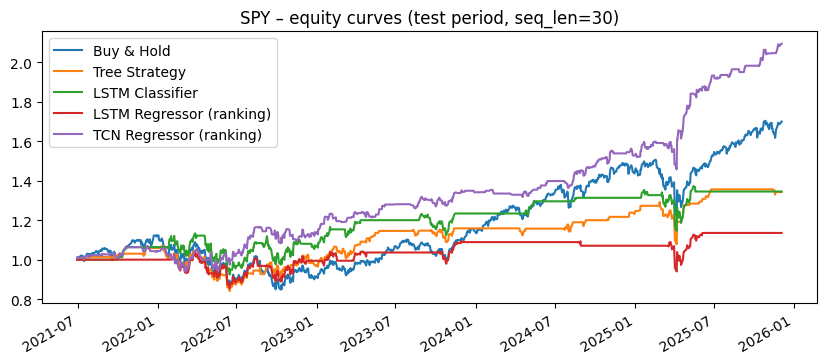

In [36]:
plt.figure(figsize=(10, 4))
equity_bh.plot(label="Buy & Hold")
equity_tree.plot(label="Tree Strategy")
equity_lstm_cls.plot(label="LSTM Classifier")
equity_lstm_reg.plot(label="LSTM Regressor (ranking)")
equity_tcn.plot(label="TCN Regressor (ranking)")
plt.legend()
plt.title(f"{ticker} – equity curves (test period, seq_len={seq_len})")
plt.show()
